<a href="https://colab.research.google.com/github/m3sibti/genomic_datascience/blob/master/PixelMotifGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Preparation

#### Download links for files

In [0]:
import requests
from bs4 import BeautifulSoup

In [0]:
web_main_link = "http://jaspar.genereg.net"

Step by step procedure

In [0]:
'''
# make simple request
r = requests.get(f"{web_main_link}/search?", params= dict(
                 page=1,
                 q="Homo sapiens",
                 tax_group="vertebrates",
                 page_size=250,
                 collection="CORE"))

soup = BeautifulSoup(r.text, "html.parser")

tags = soup.find("table", id = "search_table")

tags2 = tags.find_all("tr")
len(tags2)

rowsWithoutHeader = tags2[1:]
len(rowsWithoutHeader)

linksToData = []
for row in rowsWithoutHeader:
  dataItemLink = row.find("td", id='profile_summary').find('a').get('href')
  linksToData.append(web_main_link + dataItemLink)

linksToData
'''

A Function to extract all the links from the given website

In [0]:
def getAllDataItemLinks(web_main_link, num_pages,
                        filter="Homo sapiens",
                        group="vertebrates"):
  linksToDownload = []
  for i in range(1, num_pages+1):
    # make requests
    r = requests.get(f"{web_main_link}/search?", params= dict(
                 page=i,
                 q=filter,
                 tax_group=group,
                 page_size=250,
                 collection="CORE"))
    
    # convert the response to html file
    soup = BeautifulSoup(r.text, "html.parser")
    search_table = soup.find("table", id = "search_table")
    useful_rows = search_table.find_all("tr")
    rowsWithoutHeader = useful_rows[1:]
    for row in rowsWithoutHeader:
      dataItemLink = row.find("td", id='profile_summary').find('a').get('href')
      linksToDownload.append(web_main_link + dataItemLink)

  # remove repitions because they were 870 instead of 810
  listWithNoRepition = list(dict.fromkeys(linksToDownload))
  '''
   after this process they remain 810,
   which are the number of homo sepian items at the website
   '''
  return listWithNoRepition


In [0]:
listOfLinks = getAllDataItemLinks("http://jaspar.genereg.net", num_pages=5)
len(listOfLinks)

810

Gather the downloadable links from data items

In [0]:
downloadableFiles = []

for flink in listOfLinks:
  r = requests.get(flink)
  soup = BeautifulSoup(r.text, "html.parser")
  body_box = soup.find_all("div", "box-body")[4]
  itemToGo = body_box.find('a')
  if itemToGo != None:
    downloadableFiles.append(itemToGo.get('href'))


In [0]:
print(f"we have total {len(downloadableFiles)} downloadable files")

we have total 323 downloadable files


Write your data into files

In [0]:
with open('linksToGetMotifs.txt', 'w') as f:
    for item in downloadableFiles:
        f.write(f"{web_main_link + item}\n")

Downloadable files

In [0]:
webLinks = [web_main_link + item for item in downloadableFiles]

In [0]:
len(webLinks)

323

#### Visit Links

In [0]:
# len(webLinks)

323

In [0]:
import urllib
import os
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

Downlad File

In [0]:
!wget -O motifLinks.txt -q "https://nustedupk0-my.sharepoint.com/:t:/g/personal/smalik_mscse18_rcms_nust_edu_pk/EWa8FZcPR2tEuQ-R9HCUJOMBoXmW5HC-90yFk07rFYD5Ng?e=L5JLSZ&download=1"

In [0]:
f = open("motifLinks.txt", 'r')
motifLinks = f.read().split('\n')
motifLinks = motifLinks[:-1]

In [4]:
len(motifLinks)

323

##### Get Motifs from HTML

A Function to get motifs using `how_many`

In [0]:
def getMotif(webLinks, how_many=1):

  def getProperMotifs(linkToVisit):
    r = requests.get(linkToVisit)
    soup = BeautifulSoup(r.text, 'html.parser')
    allMotifs = soup.find_all('pre')
    return allMotifs

  if how_many == 1:
    firstLink = webLinks[0]
    allMotifs = getProperMotifs(firstLink)
    myMotifs = [l.text for l in allMotifs if len(l.text) > 2]
    return myMotifs

  else:
    motifLists = []
    for mLink in webLinks[:how_many]:
      collectionName = mLink.split('/')[4]
      allMotifs = getProperMotifs(mLink)
      myMotifs = [l.text for l in allMotifs if len(l.text) > 2]
      motifLists.append({collectionName: myMotifs})
    return motifLists


use this function to make a call for them

In [0]:
# motifLists = getMotif(motifLinks, how_many=1)

##### Download Motif Files

Create downloadable links

In [0]:
def createDownloadLinks(motifLinks):
  motifDownloableLinks = []
  for li in motifLinks:
     nl = li.split('/')
     nl.insert(3, 'download')
     nl[-1] = nl[-1] + '.sites'
     separter = '/'
     downloadableLink = separter.join(nl)
     motifDownloableLinks.append(downloadableLink)

  return motifDownloableLinks

In [0]:
downloadableLinks = createDownloadLinks(motifLinks)

In [8]:
downloadableLinks[0]

'http://jaspar.genereg.net/download/sites/MA0007.2.sites'

Download Files

In [0]:
# set the directory name
dir_name = 'data_files'

# create the directory if not already
os.makedirs(dir_name, exist_ok=True)

In [10]:
# download files for motif dataset

# currently downloading only 10 files - change it according to your requirement,
print('Downloading 5 Motif Files....')
for ilink in tqdm(downloadableLinks[:5]):
  fileName = ilink.split('.sites')[0].split('/')[-1]
  urllib.request.urlretrieve(ilink, f'{dir_name}/{fileName}.txt')

In [0]:
# remove data files when not needed
# !rm -r data_files

#### Extract data from files

In [11]:
file_paths = sorted([ dir_name+"/"+f for f in os.listdir(dir_name) ])
file_paths

['data_files/MA0007.2.txt',
 'data_files/MA0259.1.txt',
 'data_files/MA1100.1.txt',
 'data_files/MA1631.1.txt',
 'data_files/MA1632.1.txt']

In [12]:
first_path = file_paths[0]
first_path

'data_files/MA0007.2.txt'

In [0]:
file_data = open(first_path, 'r')
m_data = [ k for k in file_data.read().split('\n') if not k.startswith('>')]
combine_data = ''.join(m_data)

In [26]:
print(f'we have total {len(combine_data)} alphabets in this file {first_path}')

we have total 1288690 alphabets in this file data_files/MA0007.2.txt


In [15]:
img_shape = (16, 16)
img_size = 16*16
total_imgs = len(combine_data) // img_size
print("our image size 16 * 16 = ", img_size)
print("total images from this file ", total_imgs)

our image size 16 * 16 =  256
total images from this file  5033


In [0]:
imgs_data = []
for i in range(total_imgs):
  start = i * img_size
  end = (i+1) * img_size
  imgs_data.append(combine_data[start:end])

In [17]:
imgs_data[:3]

['aacaatctcactcaaagatggatatgatgattttatgagacttttcagagAGGAACAGAGTGTTCtgtttgcatagagaatagtcacattgtgttaggagcatgctgttactattaaagttgtgttaaaaaattaataatcttgtaatgcactatttggaaacgtAGGAACAGAGTGTGCagtcaactcagccagcagtgtttgaattagcctcagagacagaggcttgtatagctgtcctttactgcgtggctgg',
 'ccccgtgccatggggcagtgtgttAGGAACAGAGTGTGCatttgttctcatcttttcaacaacccttgggctgaatgggactctatccgtccagctcattcacctttaactcaggcttttcatggggctgggctgcctcAGGAACAGAGTGTTCagccaaagcacagcttcacctctctcctcctggccttatctgatctggccatagaagtggtcctacagctgtgtgcaggaaggctgtatattttaacaagAG',
 'GAACAGAGTGTGCtgttgagaatagaggacaatgaattaagaatcgggcctagaaaacactggttgaattttttctaaatgttcttatattaagcctttgtcagaactggaggAGGAACAGAGTGTTCcaaagccttggacccatgacaaaaatctcttcttctgaatttttcatcatgatttctataaattctctttgatttagaaccatacttgtattctctacctAGGAACAGAGTGTTCctattgattgttt']

Function to convert characters into numerical values

In [0]:
def giveNumberAgainstChar(char):
  if char == 'a':
    return 0
  elif char == 'c':
    return 85
  elif char == 't':
    return 170
  elif char == 'g':
    return 255

#### Create Image Data and Visualize

Create a training batch

In [0]:
# full training images
x_train = np.empty(shape=(total_imgs, 16, 16))

for i, img_data in enumerate(imgs_data):
  # convert strings to lower case
  img_data = img_data.lower()
  # convert characters into numbers
  img_data = [giveNumberAgainstChar(i) for i in img_data]
  x_train[i] = np.array(img_data).reshape(16, 16)

In [20]:
x_train.shape

(5033, 16, 16)

Display top images from training batch 

In [0]:
def show_images(img_list):
  plt.figure(figsize=(10, 10))
  for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(str(i+1))
    plt.imshow(img_list[i], cmap='binary')

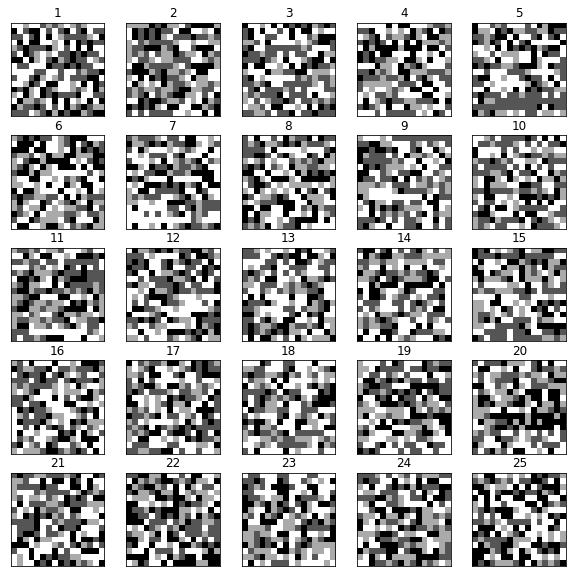

In [28]:
show_images(x_train)